# Introduction à Dask

In [1]:
# Les classiques
import numpy as np
import matplotlib.pyplot as plt

# "Scheduler" dask
from dask.distributed import LocalCluster, Client

# Structures de données
import dask
import dask.bag as db
import dask.array as da
import dask.dataframe as dd

# Misc
from time import sleep

---

### Préliminaire

Pour chronométrer le temps d'exécution d'une cellule, on utilisera la "commande magique" `%%time` qui permet de mesurer le temps d'exécution d'une cellule entière, de la manière suivante :

In [2]:
%%time

sleep(1)  # on fait dormir python  pendant 1 s

Wall time: 1.01 s


La partie qui nous intéresse est ce qui suit `Wall time:`, soit ici 1 seconde.

---

---

---

## PARTIE 1 
### Usages basiques de `dask`

Dans cette partie, on va considérer un premier cas trivial de parallélisation. Cela va permettre de se rendre compte effectivement de son effet sur l'exécution d'un grand nombre de tâches un peu longues.

On se familiarisera aussi avec l'instanciation explicite d'un `cluster`, d'un `client` et le suivi des calculs sur le *dashboard* `dask`.

---

### Question 1

On va commencer par coder une fonction qui évalue **très lentement** le carré d'un nombre.

Complétez la fonction `square` suivante de telle sorte à ce qu'elle retourne *le carré* de l'argument `x` *en prenant une seconde*. On pourra utiliser pour cela la fonction `sleep(n)` qui fait arrête le programme pendant `n` secondes avant de passer à l'exécution de la ligne suivante.

In [3]:
%%time

def square(x):
    # à compléter
    x_square = x**2
    sleep(1)
    return x_square
    
square(3)

Wall time: 1.01 s


9

On peut à présenter tester l'inefficacité de notre fonction en calculant le carré des 20 premiers entiers et en vérifiant que cela prend bien 20 s. On pourra utiliser la fonction `map()`

In [4]:
%%time

# à compléter
first_integers = np.arange(20)

first_squares = list(map(square, first_integers))

Wall time: 20.1 s


In [5]:
# %%time

# first_squares = [square(i) for i in first_integers]

---

### Question 2

On va à présent essayer de paralléliser cette opération qui est assez trivialement *embarassingly parallel* (c'est-à-dire qu'on peut appliquer la fonction `square` indépendamment sur chaque élément de la liste, sans avoir besoin du résultat d'une autre opération).

Pour cela, on va utiliser le module `dask.bag`, importé précédemment sous l'alias `db`. 

Un `bag` est essentiellement un ensemble non-ordonné d'éléments conçu pour y appliquer des opérations en parallèle; et typiquement utilisé dans les problèmes *embarassingly parallel*.

Commencez par créer un bag `first_int_bag` contenant les 20 premiers entiers. On pourra utiliser `db.range` ou `db.from_sequence`. 

In [6]:
# à compléter
first_int_bag = db.from_sequence(first_integers)
# first_int_bag = db.from_sequence(first_integers, npartitions=10)

Appliquez maintenant la fonction `square` à cet ensemble en utilisant la méthode `.map`, qui applique une fonction `f` donnée à l'ensemble des éléments du `bag` :

In [7]:
%%time

# à compléter
first_sqr_bag = first_int_bag.map(square)   # mieux que for el in first_int_bag car on demande pas explicitement les éléments


Wall time: 0 ns


Cette opération est plutôt rapide ! Il s'agit à présent de vérifier le résultat.

Pour cela, affichez chaque élément du résultat dans le terminal.

In [8]:
%%time

for el in first_sqr_bag:
    # à compléter
    print(el)

0
1
4
9
16
25
36
49
64
81
100
121
144
169
196
225
256
289
324
361
Wall time: 9.06 s


On devrait se rendre compte que cela met un certain temps à être executé - temps *plus long* même que dans la version précédente.

C'est parce que le simple appel à la méthode `.map` ne suffit pas pour calculer le résultat : il faut encore dire à `dask` d'effectivement réaliser les calculs qu'on lui a demandés. C'est ce qui se passe implicitement lorsque qu'on utilise la fonction `print` par exemple. En pratique, il vaut cependant mieux demander explicitement avant tout affichage des résultats.

Pour cela, compléter la cellule suivante pour calculer et charger les données dans une variable `first_sqr_computed`, au moyen de la méthode `.compute()`.

In [9]:
%%time 

# à compléter
first_sqr_computed = first_sqr_bag.compute()

Wall time: 8.24 s


Cela prend toujours un certain temps, supérieur à celui sans utilisation de la structure de`bag`. 

Il s'agit en fait d'un problème de partition. Notre jeu de données doit être partitionné en sous-ensembles qui vont être traités séparemment, chacun par un *worker* `dask` : ici, le fait de ne pas avoir préciser de nombre de partition fait que `dask` a supposé automatiquement le nombre de partitions - ici 1 : il n'y a donc eu aucune parallélisation des calculs.

Modifiez la cellule suivante pour ajuster le nombre de partitions de notre `bag`. Essayez de trouver la valeur optimale de partitions, et essayez d'en déduire combien de `workers` ont été lancés de manière implicite. 

In [10]:
%%time 

first_sqr_bag.npartitions  = 10     #  nb de sous ensemble (par def tous de la meme taille)
first_sqr_computed = first_sqr_bag.compute()

Wall time: 7.13 s


---

### Question 3

On va à présent dire à `dask` explicitement la puissance de calcul qu'il peut utiliser. 

Pour cela, on va utiliser les structures `LocalCluster` et `Client` importées précédemment. 

Commencez par connaitre le nombre de coeurs physiques de votre machine - éventuellement *hyperthreadés* - c'est-à-dire avec la capacités de réaliser plusieurs tâches **réellement** *en parallèle*. Cette information est en général accessible dans les menu Paramètres de votre ordinateur, ou en bash avec les commandes :

```bash
grep ^cpu\\scores /proc/cpuinfo | uniq |  awk '{print $4}'
```
(nombre de coeurs *physiques*)

ou
```bash
grep -c ^processor /proc/cpuinfo
```
(nombre de coeurs *pratiques*).

Complétez ensuite les lignes suivantes pour définir le nombre de coeurs à attribuer ) `dask`, et brancher le client sur le cluster ainsi défini. Attention à ne pas attribuer trop de coeurs à `dask`, et à en conserver un de libre pour faire tourner les autres processus de votre ordinateur !

In [11]:
cluster = LocalCluster(
    n_workers = 2,
    threads_per_worker=2
)
client = Client(cluster)

--- 

### Question 4

Une des caractéristiques **fondamentales** de `dask` est la capacité de de surveiller l'état du cluster et l'avancement des calculs via le *dashboard* `dask`. Celui-ci peut être affiché via un navigateur en y entrant le lien fournit par `dask`. 

Sous `jupyter`, il suffit de demander à afficher le `client` interactivement dans une cellule, puis de cliquer sur le lien qui sera affiché.

In [12]:
# lancez cette cellule
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 15.89 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53835,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.89 GiB
Comm: tcp://127.0.0.1:53851,Total threads: 2
Dashboard: http://127.0.0.1:53853/status,Memory: 7.94 GiB
Nanny: tcp://127.0.0.1:53839,


On peut aussi accéder à l'url explicitement en accédant à l'attribut `.dashboard_link` du `client`. Complétez la ligne suivante pour le faire afficher : 

In [13]:
# à compléter
print(f"Le dashboard est accessible à l'url : {client.dashboard_link}")

Le dashboard est accessible à l'url : http://127.0.0.1:8787/status


Les menus qui nous intéressent en général sont les menus **Status** (pour suivre l'avancée de calculs) et **Workers**, pour voir l'état du cluster.

---

#### **Note**
Dans le cas où le *dashboard* n'est pas accessible (pas de possibilité d'ouvrir une fenêtre graphique), il existe une solution de secours faisant appel à `ProgressBar` qui affichera une barre de progression dans la sortie standard. 

Il faut tout d'abord l'importer : 
```python
from dask.diagnostics import ProgressBar
```

Ensuite, on a le choix entre l'instancier de manière globale en début de script (ou de notebook), auquel cas chaque calcul fera apparaitre une bar de progression : 
```python
pb = ProgressBar()

pb.register()

...  # actual computations
```

ou alors contextuellement : 
```python
with Progressbar() as pb:
    ... # actual computations
```

Plus d'informations : 
[https://docs.dask.org/en/stable/diagnostics-local.html](https://docs.dask.org/en/stable/diagnostics-local.html)

---

---

### Question 5

On peut à présent reprendre la fin de la **Question 2**, pour constater la réduction du temps de calcul obtenue en explicitant le nombre de *workers* utilisés par `dask`.

En modifiant les lignes suivantes, réessayez de trouver le nombre optimal de partitions. Visualisez en parallèle l'état des calculs sur le *dashboard* ouvert précédemment.

In [14]:
%%time

# à compléter
first_int_bag = db.from_sequence(list(range(50)), npartitions=50)
first_sqr_bag = first_int_bag.map(square)

result = first_sqr_bag.compute()

Wall time: 13.9 s


---

---

---

## PARTIE 2
### Introduction aux `dask.array`

Dans cette partie, on s'intéressera à une caractéristique très intéressante de `dask` pour le calcul scientifique, à savoir son intégration naturelle avec les structures de données de type `numpy`. Cela permet aux usagers de ce genre d'outils une amélioration de l'efficacité des codes sans changements de pratiques majeurs.

---

### Question 6

Le but étant de se rendre compte de l'intérêt de la parallélisation par rapport à l'approche *classique*, on commence encore une fois par considérer le problème dans sa version *numpy*-esque standard.

Commencez par créer un jeu de données `images` de taille $(100 \times 1000 \times 1000)$ initialisé avec des valeurs aléatoires, par exemple en utilisant `np.random.random` de `numpy`. Ce jeu de données peut simuler un set de 100 images satellites de taille $(1000 \times 1000)$ pixels.

Si cela devait faire crasher `jupyter`, réduisez le nombre de données de (100 à 10 par exemple), et n'oubliez pas de relancer le `client` et le `cluster`.

In [15]:
%%time

# à compléter
images = np.random.random((100, 1000, 1000))

Wall time: 767 ms


On peut évaluer la taille mémoire de `images` en utilisant l'attribut `.nbytes`, pour ensuite comparer cela à la mémoire vive disponible sur son ordinateur. Si maintenant on voulait traiter 10 ou 100 fois plus de données, cela ne rentrerait probablement pas en mémoire !

In [16]:
# lancez cette cellule
print(images.nbytes)
images.nbytes / 10**6  # in MB

800000000


800.0

Effectuez à présent un petit calcul sur des données, par exemple en calculant "l'image moyenne" (c'est-à-dire moyennée selon le premier axe).

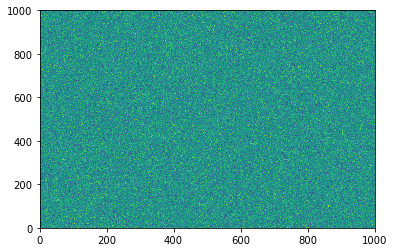

In [17]:
# à compléter

plt.pcolormesh(images.mean(axis=0))

---

### Question 7 

Dans la question précédente, on n'a pas réellement besoin d'avoir l'ensemble des données au même moment en mémoire, et on pourrait se contenter de charger les données au moment du calcul, petit bout par petit bout pour ne jamais dépasser la taille de la mémoire.

Si c'est impossible avec `numpy` directement - à moins de repenser la construction de son code - c'est bien ce pour quoi `dask` a été conçu.

Créez un tableau `images_lazy` de taille $(100 \times 1000 \times 1000)$ initialisé avec des valeurs aléatoires et `dask.array` (importé au début en tant que `da`). Affichez le ensuite interactivement avec `jupyter` pour voir sa taille théorique, ainsi que le nombre de *chunks* et la taille de chacun.

In [18]:
# à compléter
images_lazy = da.random.random((1000,1000,1000))

# affichage interactif
images_lazy

dask.array<random_sample, shape=(1000, 1000, 1000), dtype=float64, chunksize=(250, 250, 250), chunktype=numpy.ndarray>

Définissez la taille par défaut des *chunks* en utilisant la méthode `rechunk`. On fera en sorte de faire des *chunks* de $10 \times 100 \times 100$. On peut aussi spécifier la taille des chunks lors de la création du tableau. 

In [19]:
# à compléter
images_lazy = images_lazy.rechunk((250,100,100))

# affichage interactif
images_lazy

dask.array<rechunk-merge, shape=(1000, 1000, 1000), dtype=float64, chunksize=(250, 100, 100), chunktype=numpy.ndarray>

---

### Question 8 

Calculez à présent l'image moyenne `image_mean_lazy` - c'est-à-dire moyennée sur la dimension `0` - toujours de manière paresseuse, donc sans demander explicitement à charger le résultat des calculs en mémoire. Affichez interactivement l'image moyenne.

In [20]:
# à compléter
image_mean_lazy = images_lazy.mean(axis=0) # on peut dire que n'importe quel axe est l'axe du temps. On peut dire que c'est le 0 et les 2 autres lon lat

# affichage interactif
image_mean_lazy

dask.array<mean_agg-aggregate, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

Pour finir, il s'agit à présent de calculer explicitement le résultat.

Lancez le calcul et surveillez la progression dans le dashboard dask ouvert précédemment.

In [21]:
%%time

image_mean_lazy.compute()

Wall time: 8.96 s


array([[0.49178146, 0.49396993, 0.50493805, ..., 0.50482054, 0.48706237,
        0.52426454],
       [0.49019477, 0.51175528, 0.49170586, ..., 0.51274575, 0.50868654,
        0.49648036],
       [0.49192958, 0.49178422, 0.49800523, ..., 0.50947596, 0.50117371,
        0.49619794],
       ...,
       [0.49703799, 0.49966144, 0.50316085, ..., 0.49934914, 0.4938812 ,
        0.49278021],
       [0.50821543, 0.50944251, 0.50519101, ..., 0.48708196, 0.50376369,
        0.48648983],
       [0.51331611, 0.50917157, 0.48513236, ..., 0.48254696, 0.49563716,
        0.51993486]])

On peut jouer avec la taille des *chunks* pour estimer la partition optimale des données en fonction du cluster instancié et de la taille du problème.



---
---
---

## Bonus : `dask.dataframe`
 
L'utilité de `dask` dans le cadre de `pandas` ou `xarray` se situant essentiellement dans la gestion de gros volumes de données, le sujet n'a pas été abordé ici afin de ne pas avoir à télécharger trop de choses.

On peut cependant tester rapidement l'efficacité de `dask` pour effectuer des opérations usuelles sur des `dataframe` en utilisant une fonction de génération aléatoire proposée par `dask`.

In [22]:
df = dask.datasets.timeseries()
df

C:\Users\Tonton\anaconda3\lib\site-packages\dask\dataframe\core.py:5213: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [_repr_data_series(s, index=index) for _, s in meta.iteritems()], axis=1
C:\Users\Tonton\anaconda3\lib\site-packages\dask\dataframe\core.py:5213: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [_repr_data_series(s, index=index) for _, s in meta.iteritems()], axis=1


,id,name,x,y
npartitions=30,,,,
2000-01-01,int32,object,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


Testons une opération usuelle, à savoir regrouper les données par valeur de `name` identiques, puis effectuer une moyenne sur une autre dimension. Cela prendra cette forme : 

In [23]:
dg = df.groupby("name").mean()

# Comme c'est un dask.dataframe par défaut, le calcul est lazy et il faut demander explicitement le résultat
dg.compute()

,id,x,y
name,,,
Alice,1000.010704,-0.001936,-0.000011
Bob,999.945136,0.006084,0.000128
Charlie,999.931151,0.001218,0.002220
Dan,1000.015152,0.000960,-0.001116
Edith,1000.045408,-0.000588,0.000079
Frank,999.993618,-0.000070,-0.000516
George,1000.075709,0.003460,0.001884
Hannah,1000.111663,-0.000404,0.001598
Ingrid,999.916395,0.001410,0.001423


Avec de si petites données (30 lignes), le calcul est assez rapide. On peut cependant augmenter la taille des données en précisant la date de fin :

In [24]:
df_big = dask.datasets.timeseries(end="2010-12-31")

On peut à présent apprécier l'effet de la parallélisation en regardant la progression de l'opération suivante dans le dashboard `dask` : 

In [25]:
dg_big = df_big.groupby("name").mean()
dg_big.compute()

,id,x,y
name,,,
Alice,1000.012672,-0.000095,0.000184
Bob,999.999537,0.000043,0.000122
Charlie,999.993849,-0.000229,-0.000065
Dan,999.991912,0.000212,-0.000103
Edith,999.993043,-0.000287,-0.000022
Frank,999.996200,-0.000157,0.000074
George,999.996062,0.000067,0.000066
Hannah,1000.004780,0.000081,-0.000040
Ingrid,999.991158,-0.000205,-0.000009


D'autres opérations plus complexes sont possibles. Libre à vous de tester !

---
---
---

## Liens utiles

#### **Références générales**

De manière évidente, la documentation du package elle-même :
[https://docs.dask.org/en/stable/](https://docs.dask.org/en/stable/)
Elle est très bien faite et très complète.

Il est aussi intéressant de regarder quelques tutoriels sur cette chaîne, en particulier les premiers :
[https://www.youtube.com/@Dask-dev/videos](https://www.youtube.com/@Dask-dev/videos)
$\rightarrow$ certains sont d'ailleurs intégrés dans la documentation, n'hésitez pas à y jeter un oeil !

---

#### **Références plus spécifiques**

Dask delayed (API bas niveau), pour paralléliser des opérations très spécifiques :
[https://docs.dask.org/en/stable/delayed-best-practices.html](https://docs.dask.org/en/stable/delayed-best-practices.html)

Comprendre un peu mieux l'ordonnancement des tâches :
[https://docs.dask.org/en/stable/scheduling.html](https://docs.dask.org/en/stable/scheduling.html)

L'ensemble des fonctions implémentées pour les `dask.array` :
[https://docs.dask.org/en/stable/array-api.html](https://docs.dask.org/en/stable/array-api.html)

Pour en savoir plus sur les **graphes de tâches** :
[https://docs.dask.org/en/stable/graphs.html](https://docs.dask.org/en/stable/graphs.html)
$\rightarrow$ le sujet n'a pas été abordé ici car leur visualisation demande d'installer quelques packages supplémentaires, ce qui peut être plus ou moins pénible.